<a href="https://colab.research.google.com/github/coronado04-collab/Neural-Networks/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Calibration Impact on CNNs · Project 2**
##### Jorge Chamorro Pedrosa - Mario Coronado Fernández


In [1]:
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch import optim
from torch import nn
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import copy
import numpy as np
import matplotlib.pyplot as plt
import PIL
import time

from sklearn.calibration import calibration_curve

## **1. Data Preparation**
- Load CIFAR-10 dataset.
- Retrieve only the data with classes of Cats (Class 3) and Birds (Class 2).
- Split into training and test sets.






In [2]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True)

classes = {
    '0': 'bird',
    '1': 'cat'
}

In [3]:
class BirdsAndCatsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        """Dataset for filtering and preprocessing birds and cats from CIFAR-10."""
        self.data = []  # image data
        self.targets = []  # labels
        self.transform = transform  # transformation function

        # classes for birds and cats in CIFAR-10
        bird_class = 2
        cat_class = 3

        # filter birds and cats
        for i, (image, label) in enumerate(dataset):
            if label == bird_class or label == cat_class:
                self.data.append(np.array(image))
                self.targets.append(label - 2)  # relabel to boolean

        self.data = np.array(self.data)
        self.targets = np.array(self.targets)

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Returns an image and its label at a given index."""
        img, target = self.data[idx], self.targets[idx]
        img = PIL.Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target



In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = BirdsAndCatsDataset(trainset, transform=transform)
testset = BirdsAndCatsDataset(testset, transform=transform)

In [5]:
print(f"Length of birds and cats trainset: {len(trainset)}")
print(f"Length of birds and cats testset: {len(testset)}")

Length of birds and cats trainset: 10000
Length of birds and cats testset: 2000


# **Hay que elegir.**
Manual Splitting

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True, num_workers=0)
validloader = copy.deepcopy(trainloader)

trainloader.dataset.data = trainloader.dataset.data[:9000,:,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:9000]

validloader.dataset.data = validloader.dataset.data[9000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[9000:]

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

In order to make sure that our dataset has enough variability in both sets, we can use <a href="https://pytorch.org/docs/stable/data.html#torch.utils.data.SubsetRandomSampler">SubsetRandomSampler

In [7]:
"""batch_size = 64
indices = np.arange(len(trainset))
np.random.shuffle(indices)

train_idx, valid_idx = indices[:9000], indices[9000:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
validloader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)"""


'batch_size = 64\nindices = np.arange(len(trainset))\nnp.random.shuffle(indices)\n\ntrain_idx, valid_idx = indices[:9000], indices[9000:]\n\ntrain_sampler = SubsetRandomSampler(train_idx)\nvalid_sampler = SubsetRandomSampler(valid_idx)\n\ntrainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=2)\nvalidloader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler, num_workers=2)\ntestloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)'

In [8]:
# Check balance between bird and cat classes
unique, counts = np.unique(trainloader.dataset.targets, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(4520), np.int64(1): np.int64(4480)}


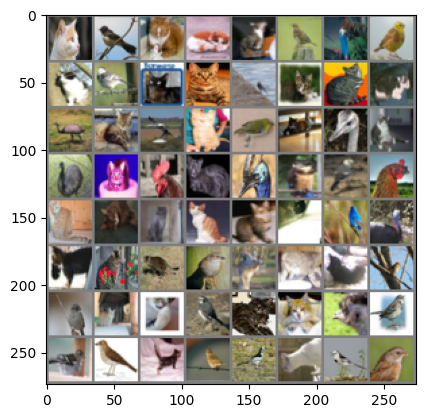

In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

traindata = iter(trainloader)
images, labels = next(traindata)

imshow(utils.make_grid(images))

## **2. Build LeNet-5 Architecture**


In [10]:
class LeNet5(nn.Module):
    def __init__(self, dimx, nlabels, prob=0.0, batchnorm=False):  # New attribute: use_batchnorm
        super().__init__()
        self.use_batchnorm = batchnorm

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)

        # BatchNorm Layers (conditionally used)
        self.bn1 = nn.BatchNorm2d(6) if batchnorm else nn.Identity()
        self.bn2 = nn.BatchNorm2d(16) if batchnorm else nn.Identity()

        # Max. pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.linear1 = nn.Linear(16 * 5 * 5, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, nlabels)

        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        # Dropout for regularization
        self.dropout = nn.Dropout(p=prob)

        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx - 4) / 2 - 4) / 2)

    def forward(self, x):
        x = self.conv1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        if self.use_batchnorm:
            x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flattening
        x = x.view(-1, 16 * self.final_dim ** 2)

        # Fully Connected Layers with Dropout
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)

        return x


# **3. Calibration Evaluation**

Let $h$ be a neural network with $h(X) =
(\hat{Y}, \hat{P})$, where $\hat{Y}$ is a class prediction and $\hat{P}$ is its probability of correctness (confidence). We would like the confidence estimate $\hat{P}$ to be calibrated, which means that $\hat{P}$ represents a true probability.

### **Reliability Diagrams**
Plot expected sample accuracy as a function of confidence.

To estimate the expected accuracy from finite samples, we group predictions into M interval bins (each of size $1/M$) and calculate the accuracy of each bin.

#### Accuracy and Confidence Calculation in Bins

- The accuracy within a bin ($B_{m}$) is given by:

$
\text{acc}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \mathbb{1}(\hat{y}_i = y_i)
$
, where $ \hat{y}_i $ and $ y_i $ are the predicted and true class labels for   sample $ i $.  

- We define the average confidence within bin ( $B_m $) as:

$
\text{conf}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \hat{p}_i
$
, where $ \hat{p}_i $ is the confidence for sample $ i $.

## **Expected Calibration Error**
We use ECE as the primary empirical metric to measure calibration.

ECE approximates:

$
\mathbb{E}_{\hat{P}} \left[ \left| P(Ŷ = Y \mid \hat{P} = p) - p \right| \right]
$

by partitioning predictions into $ M $ equally spaced bins (similar to reliability diagrams). More precisely, ECE is defined as:

$
\text{ECE} = \sum_{m=1}^{M} \frac{|B_m|}{n} \left| \text{acc}(B_m) - \text{conf}(B_m) \right|
$

where:
- $ n $ is the total number of samples  
- $ B_m $ is the set of samples in bin $ m $,  
- $ \text{acc}(B_m) $ is the accuracy in bin $ B_m $
- $ \text{conf}(B_m) $ is the average confidence in bin $ B_m $  



In [11]:
class Lenet5Extended(LeNet5):
    def __init__(self, dimx, nlabels, prob=0.0, batchnorm=False, epochs=100, lr=0.001):
        super().__init__(dimx, nlabels, prob, batchnorm)

        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.CrossEntropyLoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

        # store the loss evolution during training
        self.loss_during_training = []
        self.valid_loss_during_training = []

    def trainloop(self, trainloader, validloader):

        for e in range(int(self.epochs)):
            start_time = time.time()
            running_loss = 0.0

            self.train()
            for images, labels in trainloader:
                images, labels = images.to(self.device), labels.to(self.device).long()

                self.optim.zero_grad()
                out = self.forward(images)
                loss = self.criterion(out, labels)
                running_loss += loss.item()

                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss / len(trainloader))

            # Validation
            self.eval()
            valid_loss = 0.0
            with torch.no_grad():
                for images, labels in validloader:
                    images, labels = images.to(self.device), labels.to(self.device).long()
                    out = self.forward(images)
                    loss = self.criterion(out, labels)
                    valid_loss += loss.item()

                self.valid_loss_during_training.append(valid_loss / len(validloader))

            if e % 1 == 0:
                print(f"Epoch {e}. Training loss: {self.loss_during_training[-1]:.4f}, "
                      f"Validation loss: {self.valid_loss_during_training[-1]:.4f}, "
                      f"Time per epoch: {time.time() - start_time:.2f} seconds")

    def eval_performance(self, dataloader, a = 1):
        self.eval()
        accuracy = 0
        confidence = []  # Confidence scores
        true_labels = []  # True labels

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.forward(images)

                # Platt's scaling
                scaled_logits = logits * a
                probs = self.softmax(scaled_logits)

                # Calculate accuracy
                _, top_class = torch.max(probs, dim=1)
                equals = top_class == labels
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                # Save confidence scores and true labels
                confidence.extend(probs[:, 1].cpu().numpy())  # '1' is the label for 'cats'
                true_labels.extend(labels.cpu().numpy())

        accuracy /= len(dataloader)
        return accuracy, confidence, true_labels


In [12]:
def plot_reliability_diagram(confidences, true_labels, M=10):
    """ Plot reliability diagram """

    confidences = np.array(confidences)
    true_labels = np.array(true_labels)

    # Define bin boundaries and centers
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
    accuracies = []
    avg_confidences = []
    bin_counts = []

    # Calculate accuracy and average confidence for each bin
    for i in range(M):
        bin_indices = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i+1])
        if np.sum(bin_indices) > 0:
            bin_accuracy = np.mean(true_labels[bin_indices] == 1)
            bin_confidence = np.mean(confidences[bin_indices])
            accuracies.append(bin_accuracy)
            avg_confidences.append(bin_confidence)
            bin_counts.append(np.sum(bin_indices))
        else:
            accuracies.append(0)
            avg_confidences.append(0)
            bin_counts.append(0)

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.plot(avg_confidences, accuracies, marker='o', label='Model Calibration')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.show()

def ece(confidences, true_labels, M=10):
    """ Calculate Expected Calibration Error (ECE) """
    confidences = np.array(confidences)
    true_labels = np.array(true_labels)

    bin_boundaries = np.linspace(0, 1, M + 1)
    ece_score = 0.0

    for i in range(M):
        bin_indices = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i + 1])
        if np.sum(bin_indices) > 0:
            bin_accuracy = np.mean(true_labels[bin_indices] == 1)
            bin_confidence = np.mean(confidences[bin_indices])
            bin_proportion = np.mean(bin_indices)

            # Contribution to ECE
            ece_score += np.abs(bin_accuracy - bin_confidence) * bin_proportion

    return ece_score


def plot_loss(training_loss, validation_loss):
    plt.figure(figsize=(8, 6))
    plt.plot(training_loss, label='Training Loss', color='blue')
    plt.plot(validation_loss, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


Epoch 0. Training loss: 0.5773, Validation loss: 0.5289, Time per epoch: 2.73 seconds
Epoch 1. Training loss: 0.4962, Validation loss: 0.5070, Time per epoch: 3.28 seconds
Epoch 2. Training loss: 0.4604, Validation loss: 0.5196, Time per epoch: 2.55 seconds
Epoch 3. Training loss: 0.4359, Validation loss: 0.4670, Time per epoch: 2.49 seconds
Epoch 4. Training loss: 0.4101, Validation loss: 0.4392, Time per epoch: 2.49 seconds
Epoch 5. Training loss: 0.3832, Validation loss: 0.4421, Time per epoch: 2.72 seconds
Epoch 6. Training loss: 0.3664, Validation loss: 0.4137, Time per epoch: 3.15 seconds
Epoch 7. Training loss: 0.3481, Validation loss: 0.4290, Time per epoch: 2.48 seconds
Epoch 8. Training loss: 0.3209, Validation loss: 0.4388, Time per epoch: 2.51 seconds
Epoch 9. Training loss: 0.3013, Validation loss: 0.4552, Time per epoch: 2.47 seconds


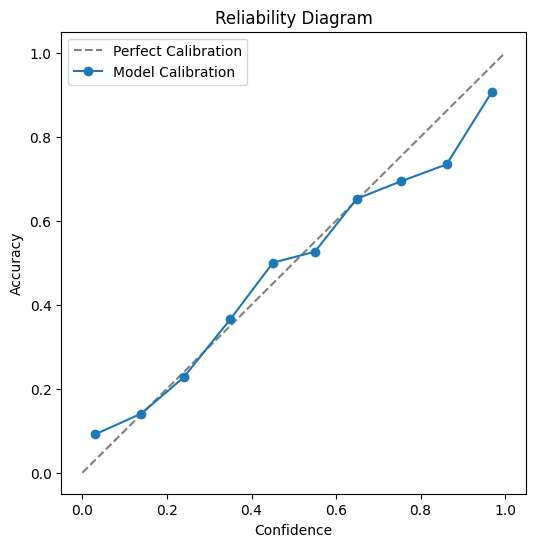

Expected Calibration Error (ECE): 0.0552


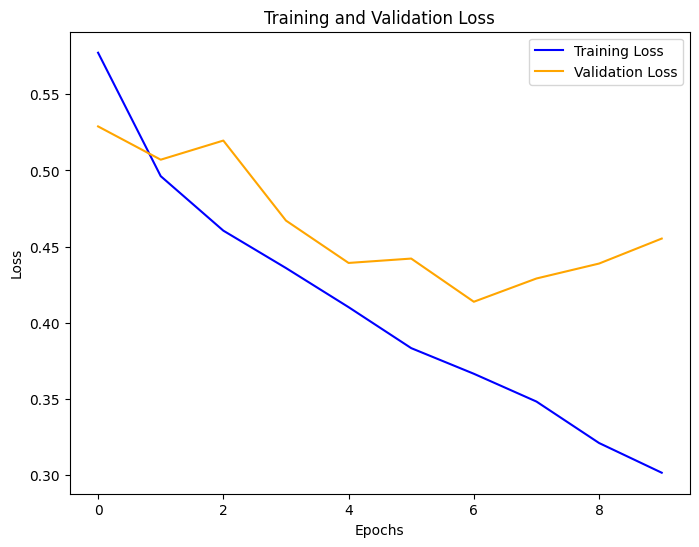

In [13]:
# Now you can call the training loop and evaluation
my_CNN = Lenet5Extended(dimx=32, nlabels=2, epochs=10, lr=0.001)
my_CNN.trainloop(trainloader, validloader)
accuracy, confidences, y_true = my_CNN.eval_performance(validloader)  # a=1 -> no temperature scaling

# Plot reliability diagram
plot_reliability_diagram(confidences, y_true)

# Compute ECE
calibration_error = ece(confidences, y_true)
print(f"Expected Calibration Error (ECE): {calibration_error:.4f}")

# Plot losses
plot_loss(my_CNN.loss_during_training, my_CNN.valid_loss_during_training)


#### Now check the result for **Batch Normalization**.


Epoch 0. Training loss: 0.5481, Validation loss: 0.4978, Time per epoch: 3.32 seconds
Epoch 1. Training loss: 0.4695, Validation loss: 0.4494, Time per epoch: 2.53 seconds
Epoch 2. Training loss: 0.4286, Validation loss: 0.4266, Time per epoch: 2.49 seconds
Epoch 3. Training loss: 0.4005, Validation loss: 0.4497, Time per epoch: 2.52 seconds
Epoch 4. Training loss: 0.3792, Validation loss: 0.4939, Time per epoch: 2.68 seconds
Epoch 5. Training loss: 0.3658, Validation loss: 0.4289, Time per epoch: 3.08 seconds
Epoch 6. Training loss: 0.3426, Validation loss: 0.4381, Time per epoch: 2.57 seconds
Epoch 7. Training loss: 0.3228, Validation loss: 0.4159, Time per epoch: 2.56 seconds
Epoch 8. Training loss: 0.3086, Validation loss: 0.4196, Time per epoch: 2.50 seconds
Epoch 9. Training loss: 0.2828, Validation loss: 0.4582, Time per epoch: 3.12 seconds


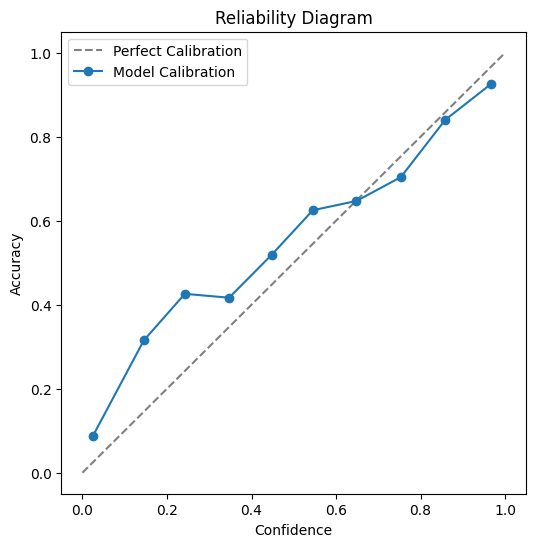

Expected Calibration Error (ECE): 0.0661


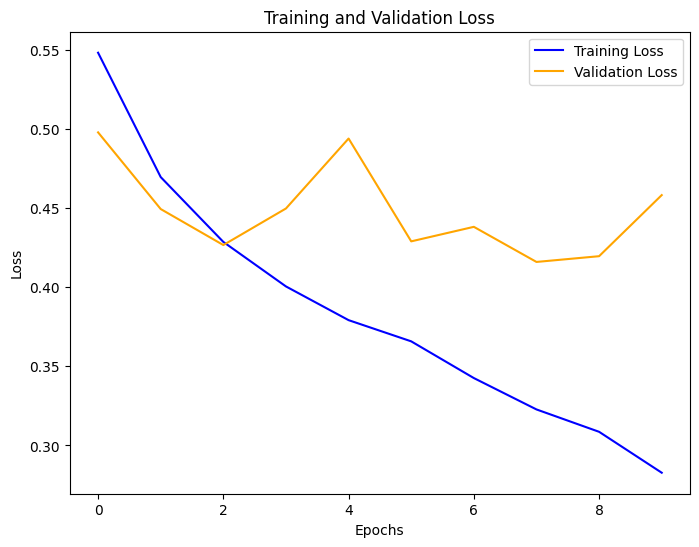

In [14]:
my_CNN_batch = Lenet5Extended(dimx=32, nlabels=2, batchnorm=True, epochs=10, lr=0.001)
my_CNN_batch.trainloop(trainloader, validloader)
accuracyBatch, confidencesBatch, y_trueBatch = my_CNN_batch.eval_performance(validloader)  # a=1 -> no temperature scaling

# Plot reliability diagram
plot_reliability_diagram(confidencesBatch, y_trueBatch)

# Compute ECE
calibration_errorBatch = ece(confidencesBatch, y_trueBatch)
print(f"Expected Calibration Error (ECE): {calibration_errorBatch:.4f}")

# Plot losses
plot_loss(my_CNN_batch.loss_during_training, my_CNN_batch.valid_loss_during_training)

#### Check full regularization with **Dropout** and **Batch Norm**.

Epoch 0. Training loss: 0.5695, Validation loss: 0.4948, Time per epoch: 2.75 seconds
Epoch 1. Training loss: 0.4987, Validation loss: 0.4872, Time per epoch: 2.54 seconds
Epoch 2. Training loss: 0.4657, Validation loss: 0.5103, Time per epoch: 2.56 seconds
Epoch 3. Training loss: 0.4408, Validation loss: 0.4291, Time per epoch: 2.81 seconds
Epoch 4. Training loss: 0.4227, Validation loss: 0.4265, Time per epoch: 2.98 seconds
Epoch 5. Training loss: 0.4029, Validation loss: 0.4271, Time per epoch: 2.47 seconds
Epoch 6. Training loss: 0.3869, Validation loss: 0.4196, Time per epoch: 2.42 seconds
Epoch 7. Training loss: 0.3733, Validation loss: 0.4298, Time per epoch: 2.55 seconds
Epoch 8. Training loss: 0.3607, Validation loss: 0.4578, Time per epoch: 3.99 seconds
Epoch 9. Training loss: 0.3426, Validation loss: 0.3925, Time per epoch: 2.72 seconds


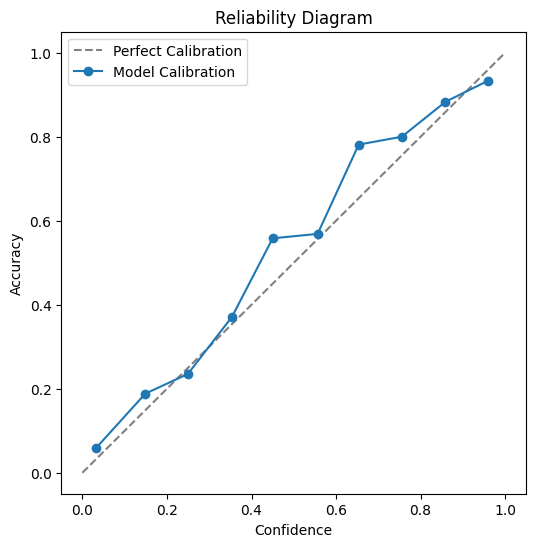

Expected Calibration Error (ECE): 0.0364


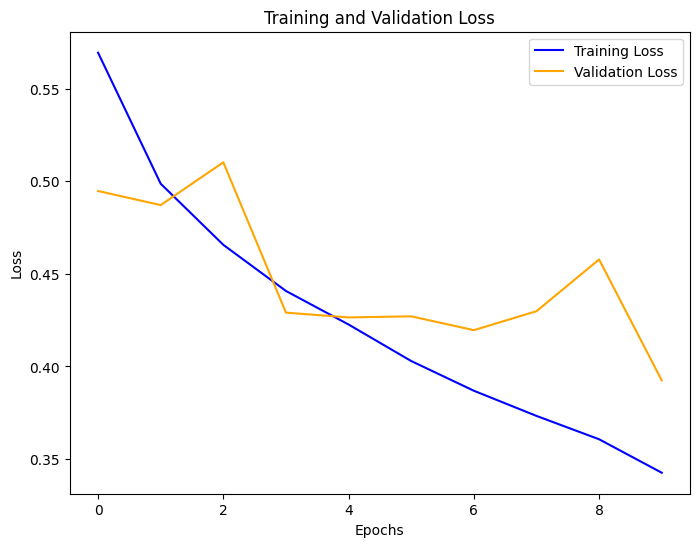

In [15]:
my_CNN_reg = Lenet5Extended(dimx=32, nlabels=2, prob=0.3, batchnorm=True, epochs=10, lr=0.001)
my_CNN_reg.trainloop(trainloader, validloader)
accuracyReg, confidencesReg, y_trueReg = my_CNN_reg.eval_performance(validloader)  # a=1 -> no temperature scaling

# Plot reliability diagram
plot_reliability_diagram(confidencesReg, y_trueReg)

# Compute ECE
calibration_errorReg = ece(confidencesReg, y_trueReg)
print(f"Expected Calibration Error (ECE): {calibration_errorReg:.4f}")

# Plot losses
plot_loss(my_CNN_reg.loss_during_training, my_CNN_reg.valid_loss_during_training)

#### **Compare** our different networks

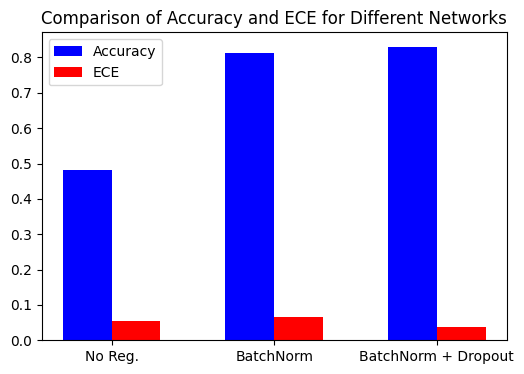

In [26]:
networks = ['No Reg.', 'BatchNorm', 'BatchNorm + Dropout']
accuracies = [accuracy, accuracyBatch, accuracyReg]
ECEs = [calibration_error, calibration_errorBatch, calibration_errorReg]

x = np.arange(len(networks))
fig, ax = plt.subplots(figsize=(6, 4))
width=0.3
ax.bar(x - width/2, accuracies, width, label='Accuracy', color='blue')
ax.bar(x + width/2, ECEs, width, label='ECE', color='red')
ax.set_title('Comparison of Accuracy and ECE for Different Networks')
ax.set_xticks(x)
ax.set_xticklabels(networks)
ax.legend()
plt.show()

# **4. Impact of Temperature Scaling**
Modify the logits: $p(a⋅z_i)$
, where $a$ is a learned scaling factor

Study the effect through reliability diagrams and ECE for different values of $a$. Optimal $a$ is the one minimizing NLL on the validation set.

In [16]:
def plot_multiple_reliability_diagrams(model, dataloader, temperature_values, num_bins=10):
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

    for a in temperature_values:
        accuracy, confidences, true_labels = model.eval_performance(dataloader, a)
        ece_score = ece(confidences, true_labels, num_bins)

        # Define bin boundaries and centers
        bin_boundaries = np.linspace(0, 1, num_bins + 1)
        bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
        accuracies = []
        avg_confidences = []

        for i in range(num_bins):
            bin_indices = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i+1])
            if np.sum(bin_indices) > 0:
                bin_accuracy = np.mean(np.array(true_labels)[bin_indices] == 1)
                bin_confidence = np.mean(np.array(confidences)[bin_indices])
                accuracies.append(bin_accuracy)
                avg_confidences.append(bin_confidence)
            else:
                accuracies.append(0)
                avg_confidences.append(0)

        plt.plot(avg_confidences, accuracies, marker='o', label=f'a={a}, ECE={ece_score:.4f}')

    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.show()


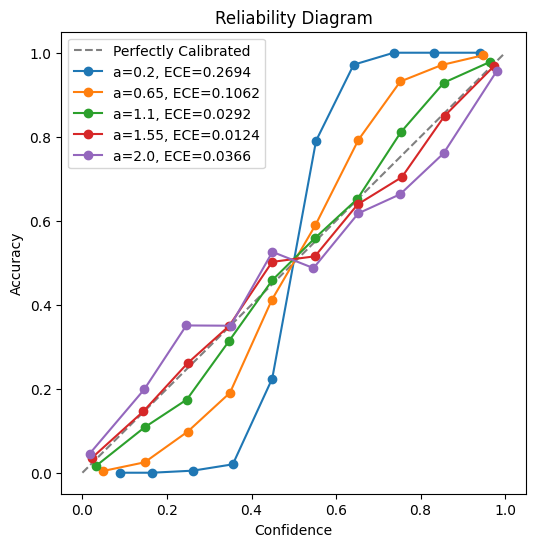

In [22]:
temperature_values = np.round(np.linspace(0.2, 2, 5), 2)
plot_multiple_reliability_diagrams(my_CNN_reg, trainloader, temperature_values)


We can see that with a<1 and a→0, the calibration curve in the interval
(1/K,1] — in this case 1/2 — tends to bow upward, while the rest of the curve tends to bow downward.

Conversely, with a>1 and a→∞, the opposite effect occurs.
The curve in the interval (1/K,1] tends to bow downward. The rest of the curve tends to bow upward. This behavior shows how adjusting the temperature parameter T influences the confidence of predictions.

### **5. Optional: Fine-tuning a Pre-Trained Model**
Our selected pre-trained model: VGG-16
- Modify the final classification layer to output 2 classes: We modify the final classification layer (<code>vgg16.classifier</code>) to output 2 classes. This is done by replacing the last layer with a new <code>nn.Linear</code> layer with 2 output features.

In [18]:
import torchvision.models as models

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [19]:
# Modify the classifier to output 2 classes
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 2)]) # Add our layer with 2 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

In [20]:
class VGG16Extended(nn.Module):
    def __init__(self, model, epochs=10, lr=0.01):
        super().__init__()

        self.model = model
        self.lr = lr
        self.optim = optim.Adam(self.model.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.CrossEntropyLoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.model.to(self.device)

        # store the loss evolution during training
        self.loss_during_training = []
        self.valid_loss_during_training = []

    def trainloop(self, trainloader, validloader):

        for e in range(int(self.epochs)):
            start_time = time.time()
            running_loss = 0.0

            self.train()
            for images, labels in trainloader:
                images, labels = images.to(self.device), labels.to(self.device).long()

                self.optim.zero_grad()
                out = self.model.forward(images)
                loss = self.criterion(out, labels)
                running_loss += loss.item()

                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss / len(trainloader))

            # Validation
            self.eval()
            valid_loss = 0.0
            with torch.no_grad():
                for images, labels in validloader:
                    images, labels = images.to(self.device), labels.to(self.device).long()
                    out = self.model.forward(images)
                    loss = self.criterion(out, labels)
                    valid_loss += loss.item()

                self.valid_loss_during_training.append(valid_loss / len(validloader))

            if e % 1 == 0:
                print(f"Epoch {e}. Training loss: {self.loss_during_training[-1]:.4f}, "
                      f"Validation loss: {self.valid_loss_during_training[-1]:.4f}, "
                      f"Time per epoch: {time.time() - start_time:.2f} seconds")

    def eval_performance(self, dataloader, a=1):
        self.eval()
        accuracy = 0
        confidence = []
        true_labels = []

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model.forward(images)

                scaled_logits = logits * a
                probs = torch.softmax(scaled_logits, dim=1)

                _, top_class = torch.max(probs, dim=1)
                equals = top_class == labels
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                confidence.extend(probs[:, 1].cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        accuracy /= len(dataloader)
        return accuracy, confidence, true_labels

Epoch 0. Training loss: 0.6951, Validation loss: 0.6923, Time per epoch: 11.37 seconds
Epoch 1. Training loss: 0.6953, Validation loss: 0.6935, Time per epoch: 11.33 seconds
Epoch 2. Training loss: 0.6957, Validation loss: 0.7008, Time per epoch: 11.26 seconds
Epoch 3. Training loss: 0.6960, Validation loss: 0.6930, Time per epoch: 11.84 seconds
Epoch 4. Training loss: 0.6939, Validation loss: 0.6932, Time per epoch: 11.15 seconds
Epoch 5. Training loss: 0.6952, Validation loss: 0.6967, Time per epoch: 11.15 seconds
Epoch 6. Training loss: 0.6943, Validation loss: 0.6938, Time per epoch: 11.16 seconds
Epoch 7. Training loss: 0.6942, Validation loss: 0.6924, Time per epoch: 11.19 seconds
Epoch 8. Training loss: 0.6941, Validation loss: 0.6938, Time per epoch: 11.36 seconds
Epoch 9. Training loss: 0.6947, Validation loss: 0.6926, Time per epoch: 11.28 seconds
Epoch 10. Training loss: 0.6941, Validation loss: 0.6992, Time per epoch: 11.26 seconds
Epoch 11. Training loss: 0.6946, Validatio

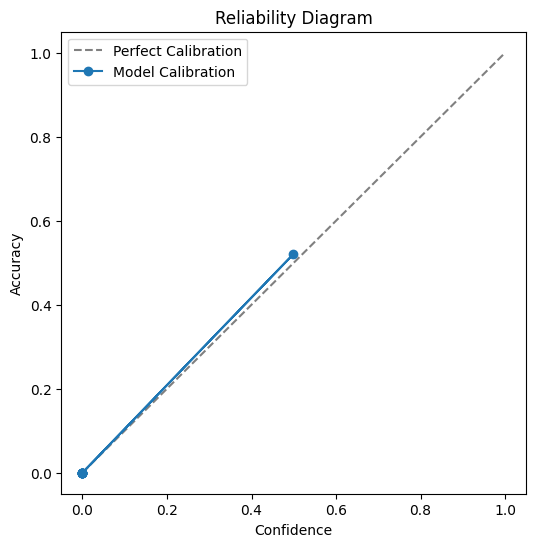

Expected Calibration Error (ECE): 0.0214


In [23]:
# Create an instance of the extended VGG16 class
my_VGG16 = VGG16Extended(model=vgg16, epochs=30, lr=1e-3)

# Train the model using your trainloader and validloader
my_VGG16.trainloop(trainloader, validloader)
accuracy, confidences, y_true = my_VGG16.eval_performance(validloader)

# Plot reliability diagram
plot_reliability_diagram(confidences, y_true)

# Compute ECE
calibration_error_VGG16 = ece(confidences, y_true)
print(f"Expected Calibration Error (ECE): {calibration_error_VGG16:.4f}")